# 5️⃣ Derive a Baseline Model
**designed by:** [datamover.ai](https://www.datamover.ai)

In [14]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display
from sklearn.model_selection import train_test_split

from r3_helpers import chain_snap
from r5_helpers import (diagnostic_plots, encode_categorical_features,
                        get_variance_inflation_factors, normlize_data,
                        regression_report)

np.random.seed(42)

pd.options.display.float_format = "{:.3f}".format
pd.set_option("display.width", 1000)

In [24]:
data = (
    pd.read_parquet("./data/data_train_cleaned.parquet")
    .pipe(
        chain_snap,
        fn=lambda x: x.duplicated().sum(),
        msg="o Number of duplicate rows",
    )
    .pipe(
        chain_snap,
        fn=lambda x: x.isna().sum().sum(),
        msg="o Number of missing values in the dataset",
    )
)

TARGET = "log(Price)"  # we consider the log of the price as the target variable

# display some info
display(data.head(3))
print(f"o Size dataframe = {data.shape}")

o Number of duplicate rows: 0
o Number of missing values in the dataset: 8


,Price,Address,Zip,Area,Room,Lon,Lat,log(Price),Zip_num,Region,Location,District,Delivery_area,AR-ratio,log(AR-ratio),log(Area),log(Room),Euclidean_distance,Haversine_distance,Manhattan_distance
0,425000,"Lamarckhof 11 I, Amsterdam",1098TK,68,3,4.944,52.352,12.960,1098,0,9,8,TK,22.667,3.121,4.220,1.099,0.055,4.174,0.072
1,520000,"Kiefskamp 24, Amsterdam",1082KA,80,2,4.872,52.330,13.162,1082,0,8,2,KA,40.000,3.689,4.382,0.693,0.048,4.959,0.063
2,700000,"Latherusstraat 54, Amsterdam",1032EC,123,6,4.915,52.393,13.459,1032,0,3,2,EC,20.500,3.020,4.812,1.792,0.030,2.712,0.042


o Size dataframe = (739, 20)


In [25]:
data.iloc[58,:]

Price                                                 585000
Address               Karel Klinkenbergstraat 1 A, Amsterdam
Zip                                                   1061AH
Area                                                      99
Room                                                       3
Lon                                                    4.836
Lat                                                   52.366
log(Price)                                            13.279
Zip_num                                                 1061
Region                                                     0
Location                                                   6
District                                                   1
Delivery_area                                             AH
AR-ratio                                              33.000
log(AR-ratio)                                          3.497
log(Area)                                              4.595
log(Room)               

In [16]:
# display missing values
display(data.isna().sum().to_frame("Missing values").T)

data = (
    data
    # remove missing values
    .dropna(how="any")
    # Drop Price, Room and Area as we will consider their corresponding log values
    .drop(columns=["Price", "Room", "Area"], axis=1)
    # Drop Address, Lat, Lon and Zip as we have engineered features in the previous section
    .drop(columns=["Address", "Lat", "Lon", "Zip"], axis=1)
    # Drop City as its variance = 0 and Delivery_area as it has too many categories
    .drop(columns=["Zip_num", "Delivery_area"], axis=1)
)

display(data.head(3))

,Price,Address,Zip,Area,Room,Lon,Lat,log(Price),Zip_num,Region,Location,District,Delivery_area,AR-ratio,log(AR-ratio),log(Area),log(Room),Euclidean_distance,Haversine_distance,Manhattan_distance
Missing values,4,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0


,log(Price),Region,Location,District,AR-ratio,log(AR-ratio),log(Area),log(Room),Euclidean_distance,Haversine_distance,Manhattan_distance
0,12.960,0,9,8,22.667,3.121,4.220,1.099,0.055,4.174,0.072
1,13.162,0,8,2,40.000,3.689,4.382,0.693,0.048,4.959,0.063
2,13.459,0,3,2,20.500,3.020,4.812,1.792,0.030,2.712,0.042


## Train quick model

In [4]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=TARGET), data[TARGET], test_size=0.2, random_state=42
)

**Test1:** 
Run the model with original features and consider the `log` features instead of the raw one.

In [5]:
# scale numerical features using StandardScaler
quantitative_features = [
    "log(Area)",
    "log(Room)",
    "log(AR-ratio)",
    "Euclidean_distance",
    "Haversine_distance",
    "Manhattan_distance",
]
categorical_features = ["Region", "Location", "District"]

X_train_num, X_test_num = normlize_data(X_train, X_test, quantitative_features)
X_train_cat, X_test_cat = encode_categorical_features(
    X_train, X_test, categorical_features
)

X_train_enc = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_enc = pd.concat([X_test_num, X_test_cat], axis=1)

In [6]:
# import statsmodels.api as sm
intercept = True

# add intercept vector if needed
if intercept:
    X_train_sm = sm.add_constant(X_train_enc)
    X_test_sm = sm.add_constant(X_test_enc)
else:
    X_train_sm = X_train_enc.copy()
    X_test_sm = X_test_enc.copy()

model_fit = sm.OLS(y_train, X_train_sm).fit()

model_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:                  OLS                Adj. R-squared:       0.876    
Dependent Variable:     log(Price)         AIC:                  -299.3955
Date:                   2023-06-07 19:56   BIC:                  -198.7308
No. Observations:       588                Log-Likelihood:       172.70   
Df Model:               22                 F-statistic:          189.7    
Df Residuals:           565                Prob (F-statistic):   3.68e-244
R-squared:              0.881              Scale:                0.033865 
--------------------------------------------------------------------------
                           Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
const                     11.7055   0.0697 167.8348 0.0000 11.5685 11.8425
log(Area)_scaled           0.2267   0.0043  53.2738 0.0000  0.2184  0.2351
log(Room)_scaled           0.1728   0.0054  31.7370 0.0000  0.1621  0.1835
log(AR-ratio)_scaled       0.1284   0.0065  19.8000 0.0000  0.1156  0.1411
Euclidean_distance_scaled -0.0834   0.0671  -1.2436 0.2142 -0.2151  0.0483
Haversine_distance_scaled  0.0160   0.0637   0.2514 0.8016 -0.1092  0.1412
Manhattan_distance_scaled  0.0499   0.0708   0.7043 0.4815 -0.0892  0.1890
Region_1                   0.8349   0.0570  14.6378 0.0000  0.7228  0.9469
Location_1                 1.5768   0.0300  52.5675 0.0000  1.5179  1.6357
Location_2                 1.1780   0.0321  36.6779 0.0000  1.1150  1.2411
Location_3                 1.1871   0.0363  32.7200 0.0000  1.1159  1.2584
Location_5                 1.5164   0.0250  60.6341 0.0000  1.4673  1.5656
Location_6                 1.1024   0.0259  42.5470 0.0000  1.0515  1.1533
Location_7                 1.6238   0.0257  63.2147 0.0000  1.5733  1.6743
Location_8                 1.2403   0.0383  32.4195 0.0000  1.1651  1.3154
Location_9                 1.4457   0.0268  53.9533 0.0000  1.3931  1.4983
District_1                 0.2126   0.0817   2.6021 0.0095  0.0521  0.3732
District_2                 0.1023   0.0825   1.2406 0.2153 -0.0597  0.2644
District_3                 0.1003   0.0803   1.2494 0.2120 -0.0574  0.2581
District_4                 0.0515   0.0794   0.6489 0.5167 -0.1045  0.2075
District_5                 0.0950   0.0793   1.1988 0.2311 -0.0607  0.2507
District_6                 0.1133   0.0790   1.4343 0.1520 -0.0419  0.2686
District_7                 0.0914   0.0771   1.1856 0.2363 -0.0600  0.2429
District_8                 0.0320   0.0774   0.4128 0.6799 -0.1201  0.1840
District_9                -0.0105   0.0788  -0.1334 0.8939 -0.1653  0.1443
--------------------------------------------------------------------------
Omnibus:              74.649      Durbin-Watson:         2.070            
Prob(Omnibus):        0.000       Jarque-Bera (JB):      144.183          
Skew:                 0.749       Prob(JB):              0.000            
Kurtosis:             4.908       Condition No.:         25765761988258848
==========================================================================
* The condition number is large (3e+16). This might indicate
strong multicollinearity or other numerical problems.
"""

**Measure Variance Inflation Factor (VIF)**

Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated, we might have difficulty in distinguishing between their individual effects on the dependent variable. Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor (VIF). **Generally, a VIF above 5 indicates a high multicollinearity**. 

In [7]:
get_variance_inflation_factors(X_train_enc)

/Users/giovanni/opt/anaconda3/envs/dv-env/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,log(Area)_scaled,inf
1,log(Room)_scaled,inf
2,log(AR-ratio)_scaled,inf
3,Euclidean_distance_scaled,78.086
4,Haversine_distance_scaled,70.564
5,Manhattan_distance_scaled,87.068
6,Region_1,16.845
7,Location_1,19.459
8,Location_2,8.039
9,Location_3,7.748


Try with selected features with low correlation between each other.

In [8]:
# scale numerical features using StandardScaler
quantitative_features = [
    "log(Area)",
    "Euclidean_distance",
]
categorical_features = ["Region"]

X_train_num, X_test_num = normlize_data(X_train, X_test, quantitative_features)
X_train_cat, X_test_cat = encode_categorical_features(
    X_train, X_test, categorical_features
)

X_train_enc = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_enc = pd.concat([X_test_num, X_test_cat], axis=1)

In [9]:
# import statsmodels.api as sm
intercept = True

# add intercept vector if needed
if intercept:
    X_train_sm = sm.add_constant(X_train_enc)
    X_test_sm = sm.add_constant(X_test_enc)
else:
    X_train_sm = X_train_enc.copy()
    X_test_sm = X_test_enc.copy()


model_fit = sm.OLS(y_train, X_train_sm).fit()

model_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Ordinary least squares
===========================================================================
Model:                 OLS                 Adj. R-squared:        0.807    
Dependent Variable:    log(Price)          AIC:                   -56.2257 
Date:                  2023-06-07 20:00    BIC:                   -38.7188 
No. Observations:      588                 Log-Likelihood:        32.113   
Df Model:              3                   F-statistic:           817.4    
Df Residuals:          584                 Prob (F-statistic):    1.54e-208
R-squared:             0.808               Scale:                 0.052851 
---------------------------------------------------------------------------
                           Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------------
const                     13.1760   0.0100 1312.3619 0.0000 13.1563 13.1957
log(Area)_scaled           0.4306   0.0096   44.9368 0.0000  0.4118  0.4494
Euclidean_distance_scaled -0.1768   0.0109  -16.2141 0.0000 -0.1982 -0.1553
Region_1                  -0.2745   0.0389   -7.0640 0.0000 -0.3508 -0.1982
---------------------------------------------------------------------------
Omnibus:                 84.902          Durbin-Watson:             2.003  
Prob(Omnibus):           0.000           Jarque-Bera (JB):          329.710
Skew:                    0.605           Prob(JB):                  0.000  
Kurtosis:                6.463           Condition No.:             4      
===========================================================================

"""

In [10]:
get_variance_inflation_factors(X_train_enc)

,feature,VIF
0,log(Area)_scaled,1.021
1,Euclidean_distance_scaled,1.289
2,Region_1,1.274


In [23]:
data.iloc[58, :] 

log(Price)           13.216
Region                0.000
Location              3.000
District              1.000
AR-ratio             25.250
log(AR-ratio)         3.229
log(Area)             4.615
log(Room)             1.386
Euclidean_distance    0.022
Haversine_distance    2.005
Manhattan_distance    0.030
eucl_inv             46.435
Name: 59, dtype: Float64

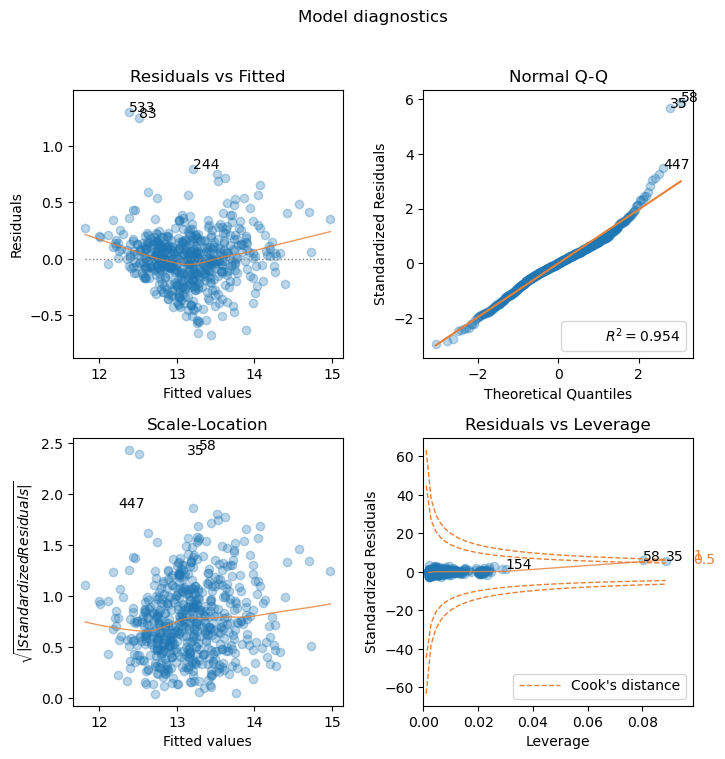

In [11]:
fig, axs = diagnostic_plots(
    model_fit=model_fit,
    X=None,
    y=None,
    figsize=(8, 8),
    limit_cooks_plot=False,
    subplot_adjust_args={"wspace": 0.3, "hspace": 0.3},
)

**Residuals vs Fitted**

This graph shows if there are any nonlinear patterns in the residuals, and thus in the data as well. One of the mathematical assumptions in building an OLS model is that the data can be fit by a line. If this assumption holds and our data can be fit by a linear model, then we should see a relatively flat line when looking at the residuals vs fitted.

An example of this failing would be trying to fit the function $f(x) = x^{2}$ with a linear regression . Clearly, with a linear regression $y = \beta_{0} + \beta_{1}x$. Clearly, the relationship is nonlinear and thus the residuals have non-random patterns.

An ideal Residuals vs Fitted plot will look like random noise; there won’t be any apparent patterns in the scatterplot and the red line would be horizontal.

**Normal Q-Q Plot**

This plot shows if the residuals are normally distributed. A good normal QQ plot has all of the residuals lying on or close to the red line.

**Scale-Location**

This plot is a way to check if the residuals suffer from non-constant variance, aka **heteroscedasticity**.

The more horizontal the red line is, the more likely the data is homoscedastic. While a typical heteroscedastic plot has a sideways “V” shape which can be caused by not capturing the non-linearities in the model (see Residuals vs Fitted plot) and merits further investigation or model tweaking. The two most common methods of “fixing” heteroscedasticity is using a weighted least squares approach, or using a heteroscedastic-corrected covariance matrix (hccm). 

**Residuals vs Leverage**

Unlike outliers, which have an unusually large $y$ value, leverage points have extreme $x$ values. This may not seem so bad at face value, but it can have damaging effects on the model because the $\beta$ coefficients are very sensitive to leverage points. The purpose of the Residuals vs Leverage plot is to identify these problematic observations.

Using the Cook’s Distance, we only need to find leverage points that have a distance greater than 0.5. In practice, there may be cases where we may want to remove points with a Cook’s distance of less than 0.5, especially if there are only a few observations compared to the rest of the data. One could argue that removing the point on the far right of the plot should improve the model. If the point is removed, we would re-run this analysis again and determine how much the model improved.

**Plot the predicted vs. actual values**

Text(0.5, 1.0, 'Residuals plot \n r-value train = 0.90 | r-value test = 0.89 ')

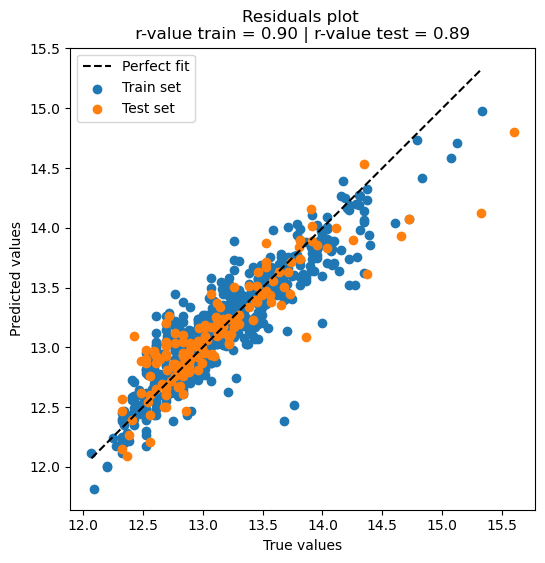

In [12]:
# get model prediction on test set
y_fit = model_fit.predict(X_train_sm)
y_pred = model_fit.predict(X_test_sm)

# plot residuals
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "--k")
ax.scatter(y_train, y_fit)
ax.scatter(y_test, y_pred)

# add legend
ax.legend(["Perfect fit", "Train set", "Test set"])
ax.set_xlabel("True values")
ax.set_ylabel("Predicted values")
ax.set_title(
    f"Residuals plot \n r-value train = {np.corrcoef(y_train, y_fit)[0,1]:.2f} | r-value test = {np.corrcoef(y_pred, y_test)[0,1]:.2f} "
)

In [13]:
# display report with extended width
with pd.option_context("display.max_colwidth", 1000):
    display(regression_report(y_pred, y_test))

,Score,Description
r-squared,0.690,"Explained variance regression score function. Best possible score is 1.0, lower values are worse."
RMSE,0.253,Root Mean Squared Error (RMSE)
MAE,0.174,Mean Absolute Error (MAE)
r-value output,0.894,Correlation between y_true and y_pred


**Benchmark model**

Linear Regression with the following dependent variables:
- `log(Area)`
- `Euclidean_distance`
- `Region`